3. In this coding exercise, you'll have an opportunity to explore the behavior of a deep neural network trained on the CIFAR10 image dataset. Follow the steps below:

* a. Construct a deep neural network (DNN) using 20 hidden layers, each comprising 100 neurons. To facilitate this exploration, employ the Swish activation function for each layer. Utilize nn.ModuleList to manage the layers effectively.

* b. Load the CIFAR10 dataset for training your network. Utilize the appropriate function, such as torchvision.datasets.CIFAR10. The dataset consists of 60,000 color images, with dimensions of 32×32 pixels. It is divided into 50,000 training samples and 10,000 testing samples. With 10 classes in the dataset, ensure that your network has a softmax output layer comprising 10 neurons. When modifying the model's architecture or hyperparameters, conduct a search to identify an appropriate learning rate. Implement early stopping during training and employ the Nadam optimization algorithm.

* c. Experiment by adding batch normalization to your network. Compare the learning curves obtained with and without batch normalization. Analyze whether the model converges faster with batch normalization and observe any improvements in its performance. Additionally, assess the impact of batch normalization on training speed.

* d. As an additional experiment, substitute batch normalization with SELU (Scaled Exponential Linear Units). Make the necessary adjustments to ensure the network self-normalizes. This involves standardizing the input features, initializing the network's weights using LeCun normal initialization (nn.init.kaiming_normal_), and ensuring that the DNN consists solely of dense layers. Observe the effects of utilizing SELU activation and self-normalization on the network's training stability and performance.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from  torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Normalizing dataset with mean and std of train_data

In [3]:
train_data = datasets.CIFAR10(root='data', train=True, download=True,transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t ,_ in train_data],dim=3)
print(imgs.shape)
print('mean:',imgs.view(3,-1).mean(dim=1))
print('std:',imgs.view(3, -1).std(dim=1))

Files already downloaded and verified
torch.Size([3, 32, 32, 50000])
mean: tensor([0.4914, 0.4822, 0.4465])
std: tensor([0.2470, 0.2435, 0.2616])


In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

#### Loading Data with torchviz.datasets

In [5]:
train_data = datasets.CIFAR10(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                                  download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


#### Initialization

In [6]:
input_size = 32*32*3
hidden_size = 100
num_classes = 10
batch_size = 128
learning_rate= 1e-04
num_hidden_layers = 20

In [7]:
train_size = len(train_data)
train_size

50000

In [8]:
test_size = len(test_data)
test_size

10000

In [9]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
torch.manual_seed(43)
val_size = 5000
train_size = len(train_data) - val_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])
len(train_dataset), len(val_dataset)

(45000, 5000)

#### DataLoader

In [12]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
# class Swish(nn.Module):
#     def forward(self, x):
#         return x * torch.sigmoid(x)

In [14]:
# class DeepNeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
#         super(DeepNeuralNetwork, self).__init__()
#         self.input_layer = nn.Linear(input_size, hidden_size)
#         self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
#         self.output_layer = nn.Linear(hidden_size, num_classes)
#         self.activation = Swish()
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.input_layer(x)
#         for layer in self.hidden_layers:
#             x = self.activation(layer(x))
        
#         x = self.softmax(self.output_layer(x))
         
#         return x


#### Biulding Model
###### In building this model in addition to what has been asked. I have added some dropout layers and kaiming_normal_

In [15]:

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepNeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(Swish())
        
        
        # Hidden layers
        for _ in range(19):  # 20 hidden layers in total
            # self.layers.append(nn.Linear(hidden_size, hidden_size))
            linear_layer = nn.Linear(hidden_size, hidden_size)
            nn.init.kaiming_normal_(linear_layer.weight)  # Apply initialization here
            self.layers.append(linear_layer)
            self.layers.append(Swish())
            self.layers.append(nn.Dropout(0.2))
        
        # Output layer with softmax activation
        self.layers.append(nn.Linear(hidden_size, output_size))
        self.layers.append(nn.Softmax(dim=1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Example usage:
input_size =  input_size  # Specify the input size according to your data
output_size = num_classes  # Specify the output size according to your task
hidden_size = 100

model = DeepNeuralNetwork(input_size, hidden_size, output_size).to(device)
print(model)


DeepNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): Swish()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Swish()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): Swish()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Swish()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=100, out_features=100, bias=True)
    (12): Swish()
    (13): Dropout(p=0.2, inplace=False)
    (14): Linear(in_features=100, out_features=100, bias=True)
    (15): Swish()
    (16): Dropout(p=0.2, inplace=False)
    (17): Linear(in_features=100, out_features=100, bias=True)
    (18): Swish()
    (19): Dropout(p=0.2, inplace=False)
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): Swish()
    (22): Dropout(p=0.2, inplace=False)
    (23): Linear(in_features=100, out_

#### Loss_Function and Optimizer

In [16]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)

#### Training
###### I have used a patience for the early stopping So that If the loss won't imporve for 5 epochs it will apply the early stopping. 
###### and also I have used a learning rate scheduler called ReduceLROnPlateau . I have given patience of 5 to this one too. So that if loss won't improve in 5 epochs it will reduce the learning rate by 0.1.

In [17]:
def model_training(model, trainloader, criterion, optimizer, num_epochs=200, patience=5):
    best_loss = float('inf')
    patience_counter = 0
    lr_scheduler = ReduceLROnPlateau(optimizer, patience=5, factor=0.1,verbose=True)
    print('Initial learning rate: {}\n'.format(optimizer.state_dict()['param_groups'][0]['lr']))
    lr = []
    train_losses = []
    model.train()
    for epoch in range(num_epochs):
        
        train_loss = 0.0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.view(inputs.size(0), -1).to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*inputs.size(0)
            

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        lr_scheduler.step(train_loss)
        print('Epoch={}, learning rate={}'.format(epoch+1, optimizer.state_dict()['param_groups'][0]['lr']))
        lr.append(optimizer.state_dict()['param_groups'][0]['lr'])
        
        print(f"Epoch={epoch+1} loss= {train_loss:7f}\n")

        # Early stopping check
        if train_loss < best_loss:
            best_loss = train_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping, no improvement in loss.")
                break
    return train_losses

In [18]:
train_losses= model_training(model, train_loader, criterion, optimizer)
train_losses

Initial learning rate: 0.0001

Epoch=1, learning rate=0.0001
Epoch=1 loss= 2.285277

Epoch=2, learning rate=0.0001
Epoch=2 loss= 2.271097

Epoch=3, learning rate=0.0001
Epoch=3 loss= 2.266976

Epoch=4, learning rate=0.0001
Epoch=4 loss= 2.261599

Epoch=5, learning rate=0.0001
Epoch=5 loss= 2.255077

Epoch=6, learning rate=0.0001
Epoch=6 loss= 2.250368

Epoch=7, learning rate=0.0001
Epoch=7 loss= 2.246651

Epoch=8, learning rate=0.0001
Epoch=8 loss= 2.243460

Epoch=9, learning rate=0.0001
Epoch=9 loss= 2.240991

Epoch=10, learning rate=0.0001
Epoch=10 loss= 2.237518

Epoch=11, learning rate=0.0001
Epoch=11 loss= 2.234636

Epoch=12, learning rate=0.0001
Epoch=12 loss= 2.228132

Epoch=13, learning rate=0.0001
Epoch=13 loss= 2.223031

Epoch=14, learning rate=0.0001
Epoch=14 loss= 2.216324

Epoch=15, learning rate=0.0001
Epoch=15 loss= 2.209195

Epoch=16, learning rate=0.0001
Epoch=16 loss= 2.200944

Epoch=17, learning rate=0.0001
Epoch=17 loss= 2.190840

Epoch=18, learning rate=0.0001
Epoc

[2.285277234573364,
 2.271097481689453,
 2.266976076049805,
 2.2615993309020994,
 2.255077072525024,
 2.2503680126953123,
 2.246650875091553,
 2.2434601023101806,
 2.240991240692139,
 2.2375175901794435,
 2.2346356105804444,
 2.2281318717193606,
 2.2230313046264647,
 2.21632440322876,
 2.2091954988098146,
 2.2009439198303222,
 2.190840163192749,
 2.1853975078582764,
 2.17905223449707,
 2.173394548416138,
 2.167432476348877,
 2.163916205368042,
 2.158703376083374,
 2.1555783323669435,
 2.149916922454834,
 2.1498418952178957,
 2.1473542273712156,
 2.145279834442139,
 2.1433394018554686,
 2.1374579642486573,
 2.137104496383667,
 2.133338218460083,
 2.1333177410125734,
 2.1314529273223877,
 2.1289720949554445,
 2.1285090935516355,
 2.127005292892456,
 2.125040632247925,
 2.125171260070801,
 2.1249311878967285,
 2.119994169616699,
 2.1164893381500245,
 2.119651559371948,
 2.1154723042297365,
 2.1131788564300535,
 2.1075567582702637,
 2.1087569770812986,
 2.1154024946594236,
 2.1058650167846

###### Early stopping had been applied and it had stopped in epoch 97 out of 200. Maybe with more number of patiance it would do better.

#### Evaluation

In [19]:
def model_validate(model, valloader, criterion):
    test_loss = 0.0
    correct = 0
    total = 0 
    test_losses=[]
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.view(inputs.size(0), -1).to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            test_loss += loss.item()*inputs.size(0)
            test_losses.append(test_loss)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss/len(test_loader.dataset)

    print(f'accuracy:{accuracy}\tloss:{test_loss}')
    return test_losses

In [20]:
eval=model_validate(model,test_loader,criterion)
eval

accuracy:36.29	loss:2.0938791236877443


[270.73138427734375,
 543.6058349609375,
 811.4711303710938,
 1080.0602416992188,
 1343.4170227050781,
 1610.0817260742188,
 1882.8088073730469,
 2145.9131469726562,
 2420.7673950195312,
 2685.100830078125,
 2956.45751953125,
 3213.280517578125,
 3475.483917236328,
 3749.147705078125,
 4009.9791870117188,
 4275.501159667969,
 4546.886871337891,
 4806.122741699219,
 5076.824676513672,
 5341.355651855469,
 5616.482727050781,
 5885.432403564453,
 6156.277038574219,
 6424.935607910156,
 6688.1248779296875,
 6951.475524902344,
 7221.87158203125,
 7489.054260253906,
 7763.228851318359,
 8027.959716796875,
 8293.777404785156,
 8564.078094482422,
 8834.61083984375,
 9098.713256835938,
 9362.223846435547,
 9635.428588867188,
 9897.029754638672,
 10158.176208496094,
 10423.538208007812,
 10693.967834472656,
 10965.550415039062,
 11234.80746459961,
 11505.9716796875,
 11785.944641113281,
 12054.291229248047,
 12319.609375,
 12586.119201660156,
 12856.043640136719,
 13129.490936279297,
 13400.1321

###### model can't do well on test data.

#### Building Model With BatchNormalization

In [21]:
class DeepNeuralNetworkWithBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepNeuralNetworkWithBatchNorm, self).__init__()

        self.layers = nn.ModuleList()

        # Input layer with Batch Normalization and Swish activation
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.BatchNorm1d(hidden_size))
        self.layers.append(Swish())

        # Hidden layers with Batch Normalization and Swish activation
        for _ in range(19):  # 20 hidden layers in total
            linear_layer = nn.Linear(hidden_size, hidden_size)
            nn.init.kaiming_normal_(linear_layer.weight)
            self.layers.append(linear_layer)
            self.layers.append(nn.BatchNorm1d(hidden_size))
            self.layers.append(Swish())
            self.layers.append(nn.Dropout(0.2))

        # Output layer with softmax activation
        self.layers.append(nn.Linear(hidden_size, output_size))
        self.layers.append(nn.Softmax(dim=1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
model_with_batch_norm = DeepNeuralNetworkWithBatchNorm(input_size, hidden_size, output_size).to(device)
model_with_batch_norm

DeepNeuralNetworkWithBatchNorm(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Swish()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Swish()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Swish()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=100, out_features=100, bias=True)
    (12): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Swish()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=100, out_features=100, bias=True)
    (16): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_sta

#### Training With BatchNormalization

In [22]:
optimizer_with_batch_norm = optim.NAdam(model_with_batch_norm.parameters(), lr=learning_rate)
train_losses_with_bn = model_training(model_with_batch_norm, train_loader, criterion, optimizer_with_batch_norm)
train_losses_with_bn

Initial learning rate: 0.0001

Epoch=1, learning rate=0.0001
Epoch=1 loss= 2.301184

Epoch=2, learning rate=0.0001
Epoch=2 loss= 2.287567

Epoch=3, learning rate=0.0001
Epoch=3 loss= 2.276659

Epoch=4, learning rate=0.0001
Epoch=4 loss= 2.271144

Epoch=5, learning rate=0.0001
Epoch=5 loss= 2.265874

Epoch=6, learning rate=0.0001
Epoch=6 loss= 2.259150

Epoch=7, learning rate=0.0001
Epoch=7 loss= 2.252388

Epoch=8, learning rate=0.0001
Epoch=8 loss= 2.243541

Epoch=9, learning rate=0.0001
Epoch=9 loss= 2.235070

Epoch=10, learning rate=0.0001
Epoch=10 loss= 2.224892

Epoch=11, learning rate=0.0001
Epoch=11 loss= 2.214658

Epoch=12, learning rate=0.0001
Epoch=12 loss= 2.210286

Epoch=13, learning rate=0.0001
Epoch=13 loss= 2.203555

Epoch=14, learning rate=0.0001
Epoch=14 loss= 2.198874

Epoch=15, learning rate=0.0001
Epoch=15 loss= 2.195396

Epoch=16, learning rate=0.0001
Epoch=16 loss= 2.190666

Epoch=17, learning rate=0.0001
Epoch=17 loss= 2.186550

Epoch=18, learning rate=0.0001
Epoc

[2.301183776855469,
 2.2875668257141113,
 2.2766588105773926,
 2.2711439338684083,
 2.265873950805664,
 2.25915002494812,
 2.2523881011199953,
 2.2435414418029787,
 2.235069775543213,
 2.2248915254211425,
 2.214657893371582,
 2.2102864772033692,
 2.2035549543762207,
 2.198873903427124,
 2.195396441116333,
 2.19066575843811,
 2.186549543685913,
 2.1814713638305663,
 2.176513279724121,
 2.1696794890594484,
 2.1663406343078613,
 2.161684691543579,
 2.157948643951416,
 2.1505612745666505,
 2.146613364944458,
 2.139516905670166,
 2.1385923035430907,
 2.1327738508605956,
 2.1287516536712645,
 2.12447565322876,
 2.118129734573364,
 2.1144599627685547,
 2.1108901470184325,
 2.1044596675872804,
 2.1013314302062986,
 2.0970343142700196,
 2.095117261734009,
 2.0922802714538573,
 2.0857203996276854,
 2.083628055648804,
 2.0818043560791017,
 2.0791391717529297,
 2.0728859577941896,
 2.069239911956787,
 2.0674053385925295,
 2.0634382402038574,
 2.0586887501525877,
 2.0557758995056155,
 2.04961755294

Early stopping has been applied in epoch 176 out of 200.Maybe with more number of patiance it would do better.

#### Evaluation of BatchNormaization

In [23]:
eval_with_batch=model_validate(model_with_batch_norm,test_loader,criterion)
eval_with_batch

accuracy:46.32	loss:1.9929797409057617


[252.98431396484375,
 517.3618469238281,
 773.5395202636719,
 1035.4039916992188,
 1286.7606506347656,
 1544.7490539550781,
 1804.9808654785156,
 2051.1700592041016,
 2309.582962036133,
 2570.079330444336,
 2821.5414276123047,
 3078.513137817383,
 3328.421142578125,
 3575.519821166992,
 3827.966522216797,
 4076.2772064208984,
 4336.078231811523,
 4592.791275024414,
 4846.503646850586,
 5105.845199584961,
 5371.413284301758,
 5625.772201538086,
 5877.4107666015625,
 6131.085189819336,
 6386.14990234375,
 6643.410125732422,
 6894.3037109375,
 7152.331024169922,
 7406.997955322266,
 7648.931823730469,
 7898.031890869141,
 8153.753723144531,
 8406.364196777344,
 8658.288925170898,
 8913.389770507812,
 9166.103515625,
 9425.809326171875,
 9674.392868041992,
 9929.440902709961,
 10187.537826538086,
 10447.962417602539,
 10704.105056762695,
 10959.772399902344,
 11219.540344238281,
 11472.460693359375,
 11728.920654296875,
 11978.236450195312,
 12230.315078735352,
 12484.559783935547,
 12739.

###### A huge impovement has happend in loss.

#### Comparing Learning Curves with and without Batch_Normalization

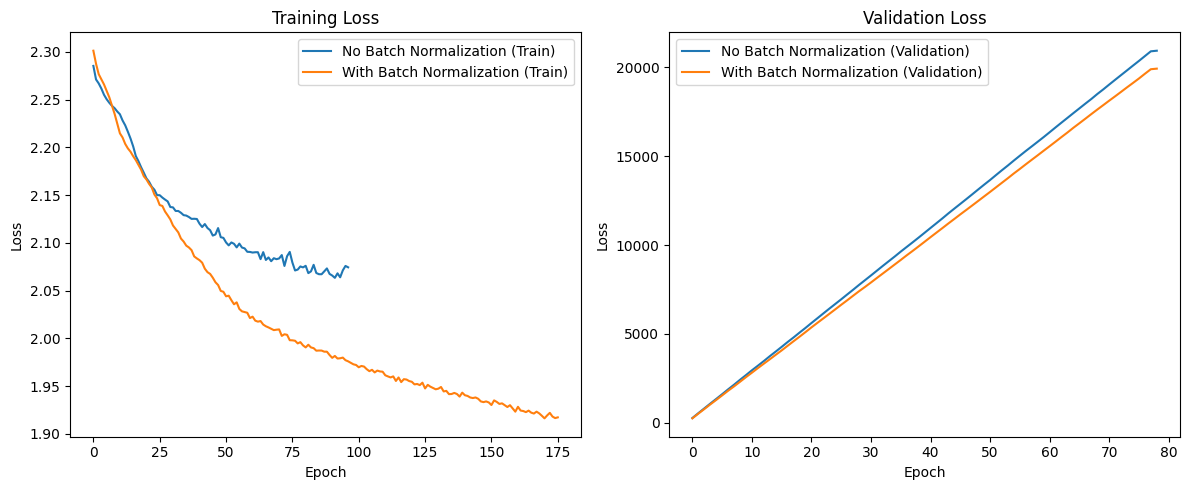

In [25]:
plt.figure(figsize=(12, 5))

# Training loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='No Batch Normalization (Train)')
plt.plot(train_losses_with_bn, label='With Batch Normalization (Train)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Validation loss curves
plt.subplot(1, 2, 2)
plt.plot(eval, label='No Batch Normalization (Validation)')
plt.plot(eval_with_batch, label='With Batch Normalization (Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### Building Model with SELU

In [26]:
class DeepNeuralNetworkWithSELU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepNeuralNetworkWithSELU, self).__init__()

        self.layers = nn.ModuleList()

        # Input layer with SELU activation
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.SELU())

        # Hidden layers with SELU activation
        for _ in range(19):  # 20 hidden layers in total
            linear_layer = nn.Linear(hidden_size, hidden_size)
            nn.init.kaiming_normal_(linear_layer.weight)
            self.layers.append(linear_layer)
            self.layers.append(nn.SELU())
            self.layers.append(nn.Dropout(0.2))

        # Output layer with softmax activation
        self.layers.append(nn.Linear(hidden_size, output_size))
        self.layers.append(nn.Softmax(dim=1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


#### Training Model with SELU

In [27]:
model_with_selu = DeepNeuralNetworkWithSELU(input_size, hidden_size, output_size).to(device)
optimizer_with_selu = optim.NAdam(model_with_selu.parameters(), lr=learning_rate)
train_losses_with_selu = model_training(model_with_selu, train_loader, criterion, optimizer_with_selu)

Initial learning rate: 0.0001

Epoch=1, learning rate=0.0001
Epoch=1 loss= 2.353951

Epoch=2, learning rate=0.0001
Epoch=2 loss= 2.356039

Epoch=3, learning rate=0.0001
Epoch=3 loss= 2.355036

Epoch=4, learning rate=0.0001
Epoch=4 loss= 2.352781

Epoch=5, learning rate=0.0001
Epoch=5 loss= 2.357074

Epoch=6, learning rate=0.0001
Epoch=6 loss= 2.352947

Epoch=7, learning rate=0.0001
Epoch=7 loss= 2.354092

Epoch=8, learning rate=0.0001
Epoch=8 loss= 2.352023

Epoch=9, learning rate=0.0001
Epoch=9 loss= 2.351256

Epoch=10, learning rate=0.0001
Epoch=10 loss= 2.354088

Epoch=11, learning rate=0.0001
Epoch=11 loss= 2.353830

Epoch=12, learning rate=0.0001
Epoch=12 loss= 2.351876

Epoch=13, learning rate=0.0001
Epoch=13 loss= 2.352609

Epoch=14, learning rate=0.0001
Epoch=14 loss= 2.347258

Epoch=15, learning rate=0.0001
Epoch=15 loss= 2.345238

Epoch=16, learning rate=0.0001
Epoch=16 loss= 2.347799

Epoch=17, learning rate=0.0001
Epoch=17 loss= 2.344751

Epoch=18, learning rate=0.0001
Epoc

###### Early stopping happened in epoch 93 out 200.Maybe with more number of patiance it would do better.

#### Evaluation of Model with SELU

In [28]:
val_losses_with_selu = model_validate(model_with_selu, val_loader, criterion )

accuracy:26.64	loss:2.1799316776275637


#### Learning Curves

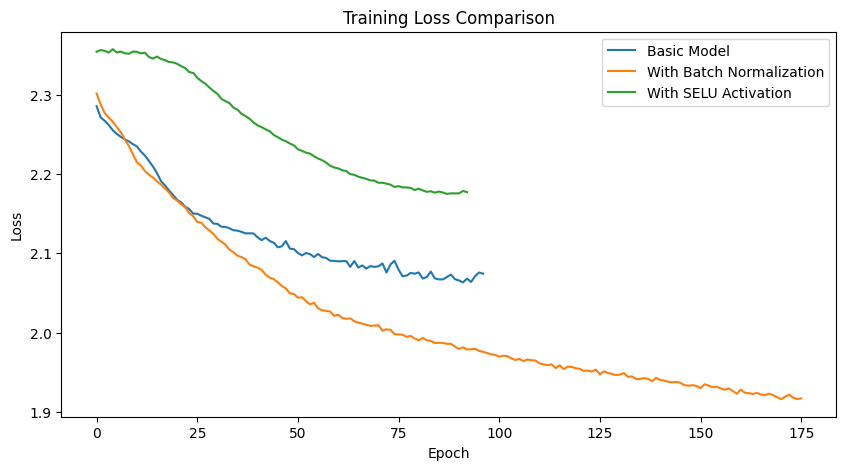

In [30]:
plt.figure(figsize=(10, 5))

# Training loss curves
plt.plot(train_losses, label='Basic Model')
plt.plot(train_losses_with_bn, label='With Batch Normalization')
plt.plot(train_losses_with_selu, label='With SELU Activation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

plt.show()